In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests
import zipfile
import io

# Download Jena Climate dataset
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
response = requests.get(url)
zf = zipfile.ZipFile(io.BytesIO(response.content))
df = pd.read_csv(zf.open(zf.namelist()[0]))

# Convert datetime
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date Time'].min()} to {df['Date Time'].max()}")



Dataset shape: (420551, 15)
Date range: 2009-01-01 00:10:00 to 2017-01-01 00:00:00


In [3]:
# Resample to hourly data
df_hourly = df.set_index('Date Time').resample('1H').mean()
df_hourly = df_hourly.dropna()

# Select features for modeling
features = [
    'T (degC)', 'p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)',
    'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)'
]
df_model = df_hourly[features].copy()
df_model = df_model.fillna(method='ffill').fillna(method='bfill')


/tmp/ipython-input-3298483051.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('Date Time').resample('1H').mean()
/tmp/ipython-input-3298483051.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model = df_model.fillna(method='ffill').fillna(method='bfill')


In [4]:
def create_sequences(data, sequence_length, forecast_horizon):
    """Create input sequences and corresponding labels"""
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length + forecast_horizon - 1, 0])  # T (degC) is index 0
    return np.array(X), np.array(y)

# Parameters
SEQUENCE_LENGTH = 120  # 5 days of hourly data
FORECAST_HORIZON = 12  # Predict 12 hours ahead

# Prepare data
data_array = df_model.values.astype(np.float32)
X, y = create_sequences(data_array, SEQUENCE_LENGTH, FORECAST_HORIZON)
print(f"Input sequences shape: {X.shape}")
print(f"Labels shape: {y.shape}")




Input sequences shape: (69910, 120, 9)
Labels shape: (69910,)


In [5]:
# Chronological split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Train: {X_train_scaled.shape[0]}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")


Train: 48937, Val: (10486, 120, 9), Test: (10487, 120, 9)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_bilstm_model(sequence_length, n_features, lstm_units=32):
    model = Sequential([
        tf.keras.layers.Input(shape=(sequence_length, n_features)),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

n_features = X_train_scaled.shape[2]
model = build_bilstm_model(SEQUENCE_LENGTH, n_features)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,809 (46.13 KB)

 Trainable params: 11,809 (46.13 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]
BATCH_SIZE = 256
EPOCHS = 10

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=callbacks,
    verbose=1
)

model.save('bilstm_weather_model.h5')



Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - loss: 0.3690 - mae: 0.4588 - val_loss: 0.1199 - val_mae: 0.2698 - learning_rate: 0.0010
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - loss: 0.1459 - mae: 0.2980 - val_loss: 0.1084 - val_mae: 0.2588 - learning_rate: 0.0010
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - loss: 0.1283 - mae: 0.2794 - val_loss: 0.1020 - val_mae: 0.2502 - learning_rate: 0.0010
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - loss: 0.1197 - mae: 0.2697 - val_loss: 0.0997 - val_mae: 0.2457 - learning_rate: 0.0010
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - loss: 0.1138 - mae: 0.2630 - val_loss: 0.1013 - val_mae: 0.2500 - learning_rate: 0.0010
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - loss: 0.1110 - mae: 0.2603 - val_loss: 0.1023 - val_mae: 0.2470 - learning_rate: 0.0010
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - loss: 0.1093 - mae: 0.2573 - val_loss: 0.0973 - val_mae: 0.2442 - learnin

In [8]:
def build_lstm_model(sequence_length, n_features, lstm_units=32):
    model = Sequential([
        tf.keras.layers.Input(shape=(sequence_length, n_features)),
        LSTM(lstm_units),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_gru_model(sequence_length, n_features, gru_units=32):
    from tensorflow.keras.layers import GRU
    model = Sequential([
        tf.keras.layers.Input(shape=(sequence_length, n_features)),
        GRU(gru_units),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Train baselines (optional)
# lstm_model = build_lstm_model(SEQUENCE_LENGTH, n_features)
# gru_model = build_gru_model(SEQUENCE_LENGTH, n_features)


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test, scaler_y, model_name):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} MAE: {mae:.4f}°C, RMSE: {rmse:.4f}°C, R²: {r2:.4f}")
    return y_true, y_pred, mae, rmse, r2

y_true, y_pred, mae, rmse, r2 = evaluate_model(model, X_test_scaled, y_test_scaled, scaler_y, "BiLSTM")


328/328 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step
BiLSTM MAE: 2.1023°C, RMSE: 2.6157°C, R²: 0.8870


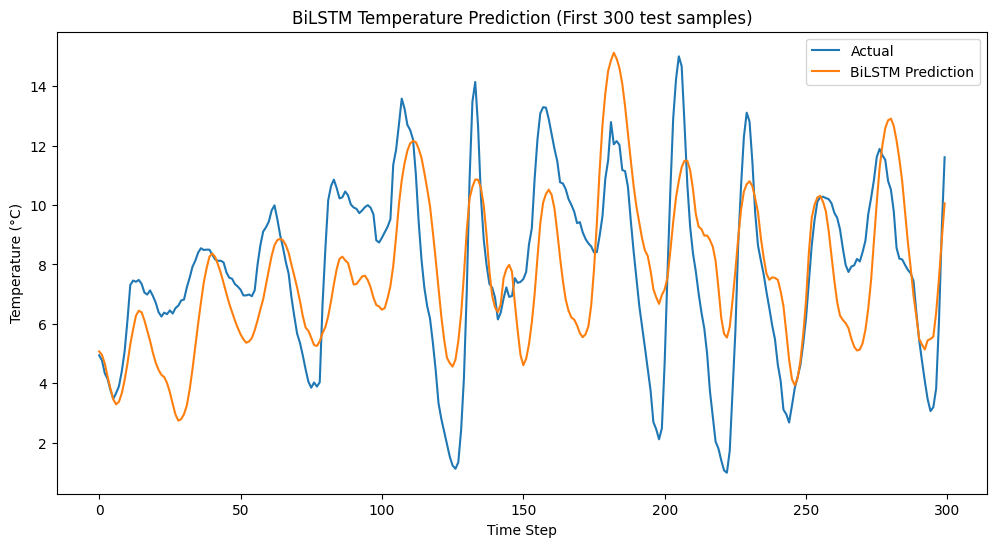

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_true[:300], label="Actual")
plt.plot(y_pred[:300], label="BiLSTM Prediction")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("BiLSTM Temperature Prediction (First 300 test samples)")
plt.show()
